<a href="https://colab.research.google.com/github/RashmiBhagya/Transfer-Leaning-With-Image-Clasifier-Banana-Detection/blob/main/banana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q



In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

Load Dataset

In [3]:
# download dataset
od.download("https://www.kaggle.com/datasets/rashmipremadasa/healty-banana-detection-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rashmipremadasa
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:13<00:00, 103MB/s]


In [295]:
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)

In [296]:
train_data_dir = "/content/healty-banana-detection-dataset/Banana/Banana/Test"
test_data_dir = "/content/healty-banana-detection-dataset/Banana/Banana/Train"


In [297]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 264 files belonging to 2 classes.
Using 238 files for training.
Found 264 files belonging to 2 classes.
Using 26 files for validation.
Found 730 files belonging to 2 classes.


In [298]:
class_names = train_data.class_names
class_names

['Chemical', 'Non-Chemical']

In [299]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 256, 256, 3)
(32,)


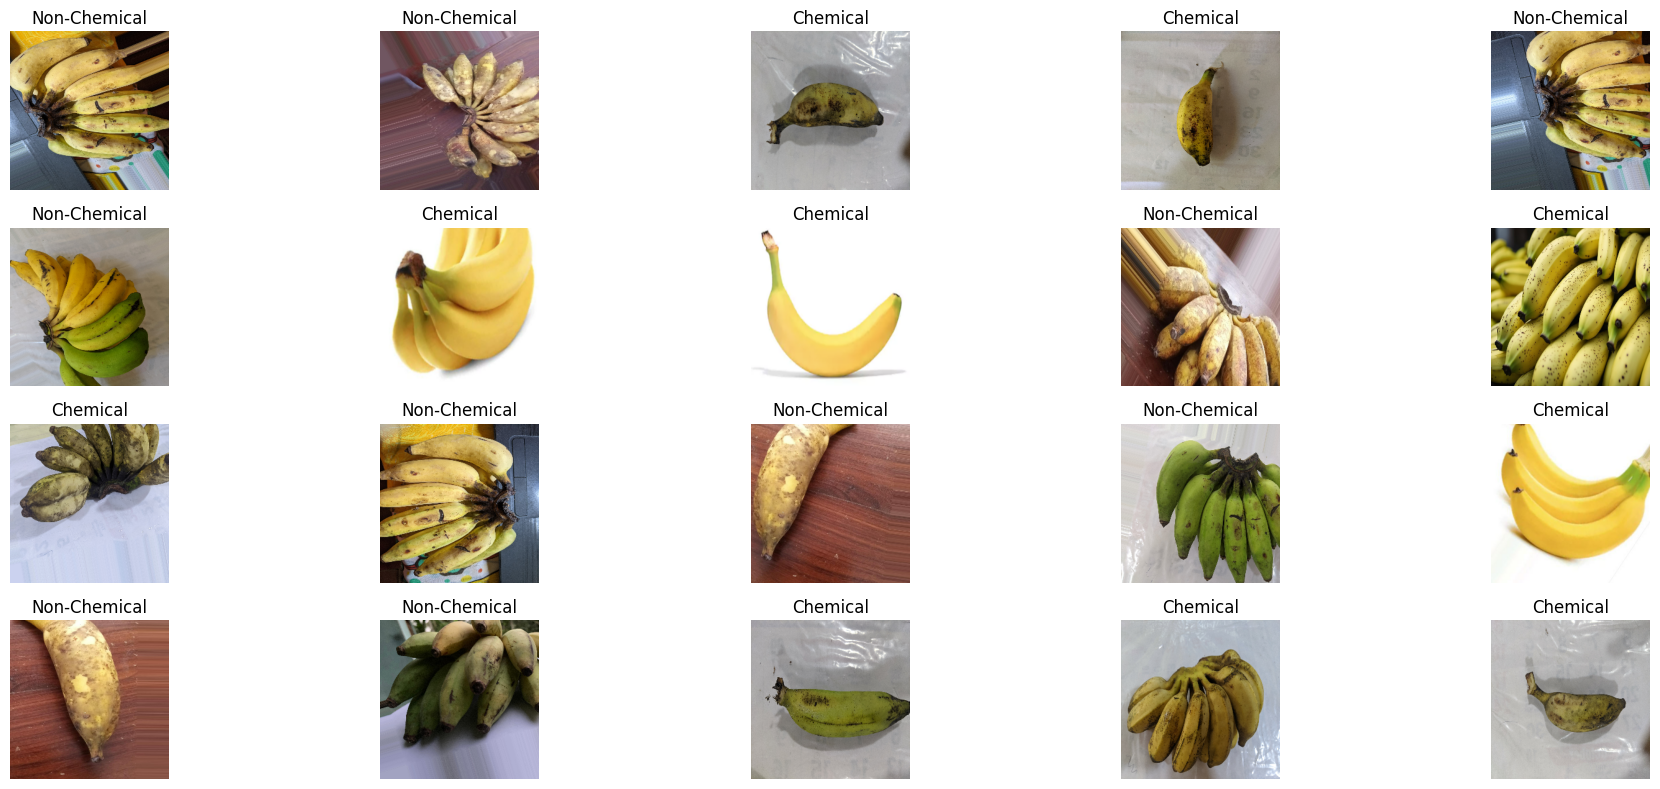

In [300]:
import matplotlib.pyplot as plt

# Plot data sample
plt.figure(figsize=(20, 8))
for image, label in train_data.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i+1)  # Adjusted to 4 rows and 5 columns
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()


Scaling Images


In [301]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[254.       255.       245.      ]
   [254.       255.       245.      ]
   [254.       255.       245.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[254.       255.       245.      ]
   [254.       255.       245.      ]
   [254.       255.       245.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[254.       255.       245.53906 ]
   [254.       255.       245.53906 ]
   [254.       255.       245.53906 ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  ...

  [[245.67578  245.67578  245.67578 ]
   [245.       245.       245.      ]
   [244.3789   244.3789   244.3789  ]
   ...
   [244.51172  229.80525  157.67578 ]
   [241.94531  227.4336   151.80513 ]
   [239.32422  225.78516  146.48293 ]]

  [[245.19922  245.67578  245.4375

In [302]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [303]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[0.7717678  0.8109835  0.8462776 ]
   [0.75061274 0.7702206  0.7819853 ]
   [0.7258272  0.73367035 0.72190565]
   ...
   [0.6278493  0.59255517 0.55726105]
   [0.63049936 0.6030484  0.57167584]
   [0.59016544 0.59016544 0.55094975]]

  [[0.7678309  0.8077819  0.8329044 ]
   [0.75695467 0.77215075 0.78489584]
   [0.7472273  0.7629136  0.77446383]
   ...
   [0.6362592  0.6009651  0.56567097]
   [0.60712314 0.57967216 0.5482996 ]
   [0.59142154 0.57916665 0.54387254]]

  [[0.7510876  0.7863817  0.8138327 ]
   [0.74105394 0.7606618  0.7841912 ]
   [0.71913296 0.73089767 0.7505055 ]
   ...
   [0.65661764 0.61740196 0.58210784]
   [0.657598   0.61446077 0.59093136]
   [0.6454197  0.6101256  0.5748315 ]]

  ...

  [[0.6261029  0.6261029  0.6261029 ]
   [0.6134191  0.6134191  0.62126225]
   [0.6168352  0.6168352  0.6246783 ]
   ...
   [0.5823223  0.566636   0.5313419 ]
   [0.5694087  0.55372244 0.5184283 ]
   [0.6014093  0.57395834 0.5425858 ]]

  [[0.6185815  0.6185815  0.618581

Transfer Learning

In [304]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(256,256,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False

Data Augmentation

In [305]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(256,256,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

Model Building

In [306]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [307]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               262272    
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21144425 (80.66 MB)
Trainable params: 2

In [308]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Model Training

In [309]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/10
8/8 [==============================] - 17s 464ms/step - loss: 0.7233 - accuracy: 0.6639 - val_loss: 0.4044 - val_accuracy: 0.8462
Epoch 2/10
8/8 [==============================] - 12s 340ms/step - loss: 0.3241 - accuracy: 0.8655 - val_loss: 0.3443 - val_accuracy: 0.8077
Epoch 3/10
8/8 [==============================] - 13s 324ms/step - loss: 0.1683 - accuracy: 0.9412 - val_loss: 0.1685 - val_accuracy: 0.9615
Epoch 4/10
8/8 [==============================] - 12s 302ms/step - loss: 0.0688 - accuracy: 0.9790 - val_loss: 0.0986 - val_accuracy: 0.9231
Epoch 5/10
8/8 [==============================] - 13s 325ms/step - loss: 0.0371 - accuracy: 0.9958 - val_loss: 0.1151 - val_accuracy: 0.9231
Epoch 6/10
8/8 [==============================] - 12s 443ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0833 - val_accuracy: 0.9231
Epoch 7/10
8/8 [==============================] - 13s 321ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 8/10
8/

In [310]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 184.212 seconds


Performance Analysis

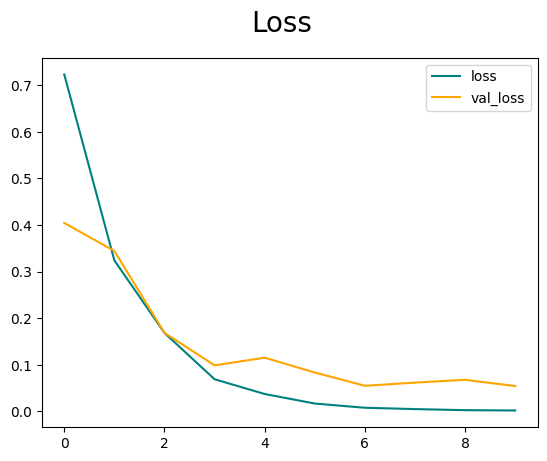

In [311]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

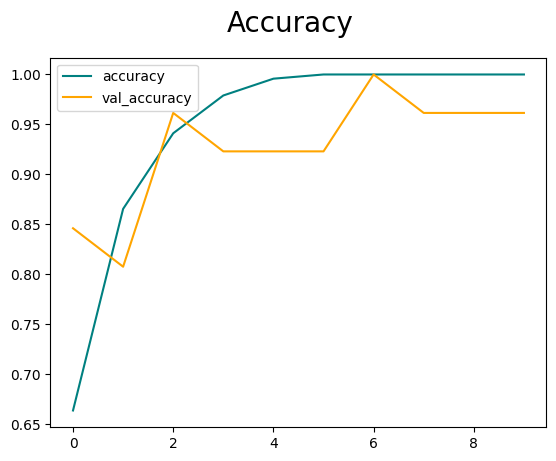

In [312]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

Model Evaluation

In [313]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [314]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 1s 752ms/step


In [315]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.60162604>

In [316]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.4099723>

In [317]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5739726>

Test

In [318]:
!pip install opencv-python -q

In [319]:
import cv2

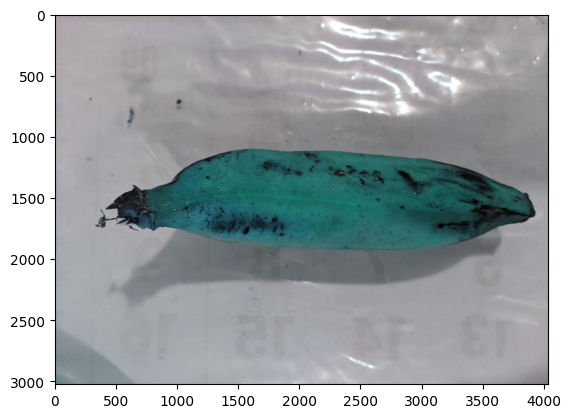

In [408]:
image = cv2.imread('/content/healty-banana-detection-dataset/Banana/Banana/Test/Chemical/Ambum/PXL_20240128_150823422.jpg')
plt.imshow(image)
plt.show()

In [409]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255


In [410]:
scaled_image.shape

TensorShape([256, 256, 3])

In [411]:
np.expand_dims(scaled_image, 0).shape

(1, 256, 256, 3)

In [412]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 25ms/step


In [413]:
yhat

array([[0.00078796]], dtype=float32)

In [358]:
class_names

['Chemical', 'Non-Chemical']

In [414]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')


Chemical
